# White blood cell classifier
### Video Tutorial in BioPrograma https://www.youtube.com/channel/UCbJAU7N9FYvwkdgSwD_1S4Q

To reproduce the same environment I used  for this notebook , download the fastai_2.yml and 
onda env create -f fastai_2.yml

Download dataset from https://www.kaggle.com/datasets/masoudnickparvar/white-blood-cells-dataset/data
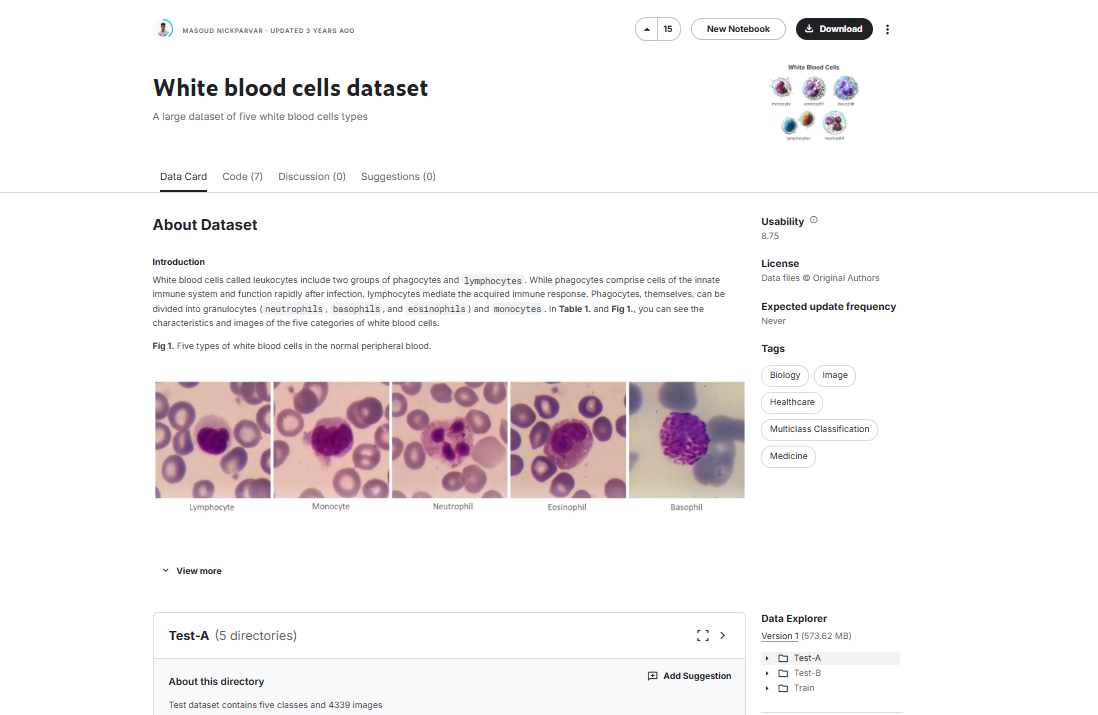

In [ ]:
#run this cell if using google colab
# ! [ -e /content ] && pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()

In [1]:
#hide
from fastbook import *
from fastai.vision.widgets import *
from matplotlib import pyplot as plt
import os
import seaborn as sns

C:\Users\bruni\AppData\Local\Temp\ipykernel_8312\4255478949.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


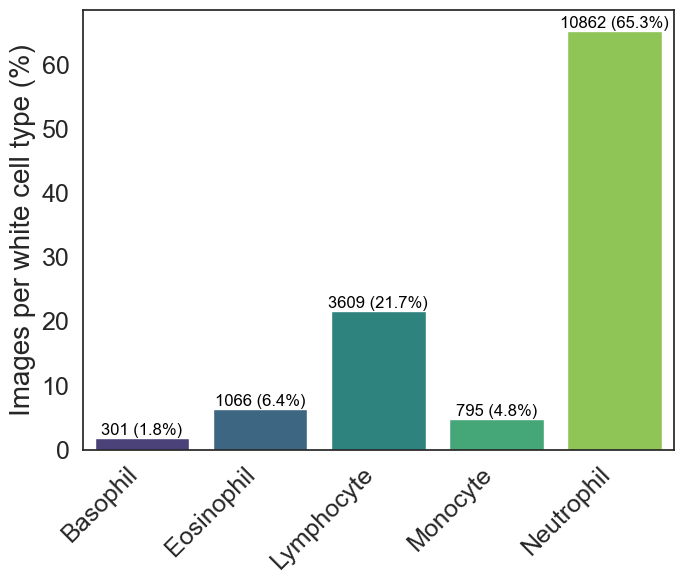

In [6]:

#Code for generating a plot of counts of percentages of images per subdirectory (cell)

root_dir = "Path to the root directory containing subdirectories" #replace this with your root directory path


file_counts = {}


for subdir, _, files in os.walk(root_dir):
  
    if subdir == root_dir:
        continue
    subdirectory_name = os.path.basename(subdir)
    file_counts[subdirectory_name] = len(files)


file_counts = dict(sorted(file_counts.items()))

s
total_images = sum(file_counts.values())
percentages = [(count / total_images) * 100 for count in file_counts.values()]

# Plot the data
sns.set(style="white")
plt.figure(figsize=(7, 6))
bars = sns.barplot(
    x=list(file_counts.keys()),
    y=percentages,
    palette="viridis",
)


for bar, count, percent in zip(bars.patches, file_counts.values(), percentages):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{count} ({percent:.1f}%)",
        ha="center",
        va="bottom",
        fontsize=12,
        color="black",
    )


plt.ylabel("Images per white cell type (%)", fontsize=20)
plt.xticks(rotation=45, ha="right", fontsize=18)           # Adjust font size for x-axis ticks
plt.yticks(fontsize=18) 
plt.tight_layout()
plt.show()


In [8]:
#Get path of your dataset directory
path = Path('white_blood_cell_dataset/')
path

Path('white_blood_cell_dataset')

In [29]:
#read images from their file paths
fns = get_image_files(path)
fns

(#16633) [Path('white_blood_cell_dataset/Basophil/20190526_162951_0.jpg'),Path('white_blood_cell_dataset/Basophil/20190526_163027_0.jpg'),Path('white_blood_cell_dataset/Basophil/20190526_163055_0.jpg'),Path('white_blood_cell_dataset/Basophil/20190526_163055_1.jpg'),Path('white_blood_cell_dataset/Basophil/20190526_163055_2.jpg'),Path('white_blood_cell_dataset/Basophil/20190526_163414_0.jpg'),Path('white_blood_cell_dataset/Basophil/20190526_163446_1.jpg'),Path('white_blood_cell_dataset/Basophil/20190526_163519_0.jpg'),Path('white_blood_cell_dataset/Basophil/20190526_163532_0.jpg'),Path('white_blood_cell_dataset/Basophil/20190526_163545_0.jpg'),Path('white_blood_cell_dataset/Basophil/20190526_163608_1.jpg'),Path('white_blood_cell_dataset/Basophil/20190526_163656_0.jpg'),Path('white_blood_cell_dataset/Basophil/20190526_163721_0.jpg'),Path('white_blood_cell_dataset/Basophil/20190526_163729_0.jpg'),Path('white_blood_cell_dataset/Basophil/20190526_163735_0.jpg'),Path('white_blood_cell_dataset

In [30]:
#building a datablock
white_cell_classifier = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [32]:
#load path
dls = white_cell_classifier.dataloaders(path)

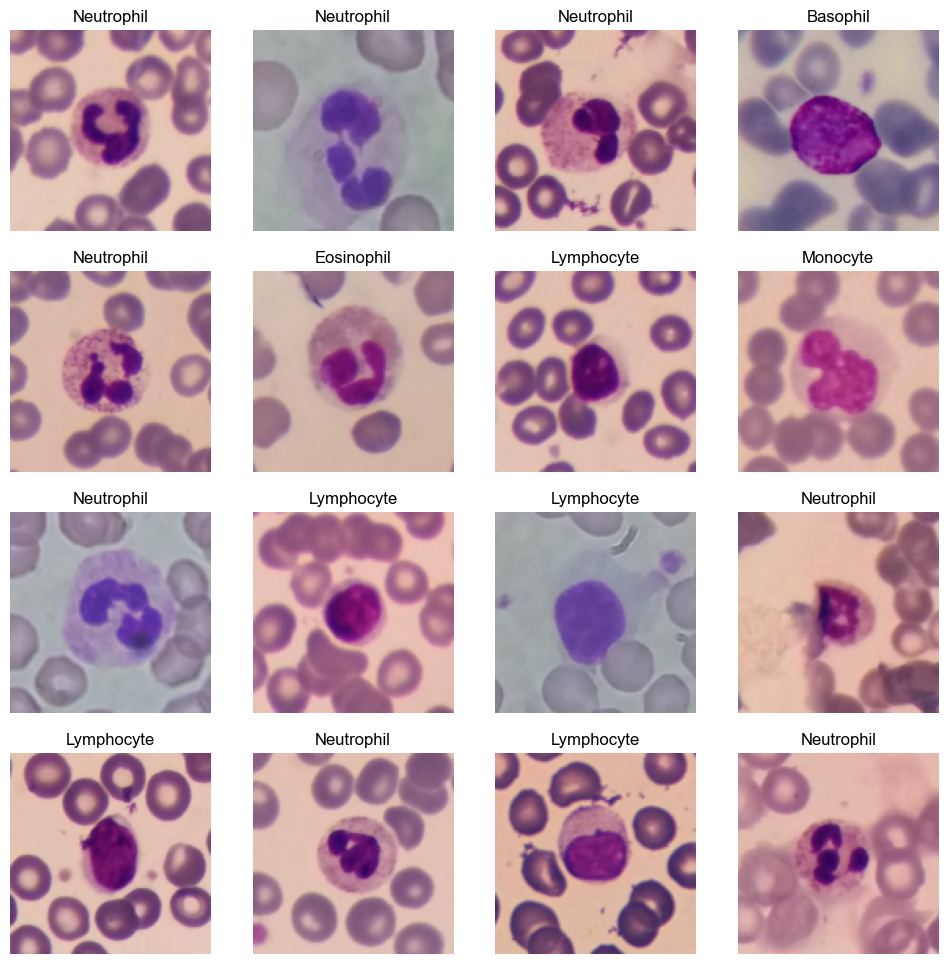

In [33]:
#check some images
dls.valid.show_batch(max_n=16, nrows=4)

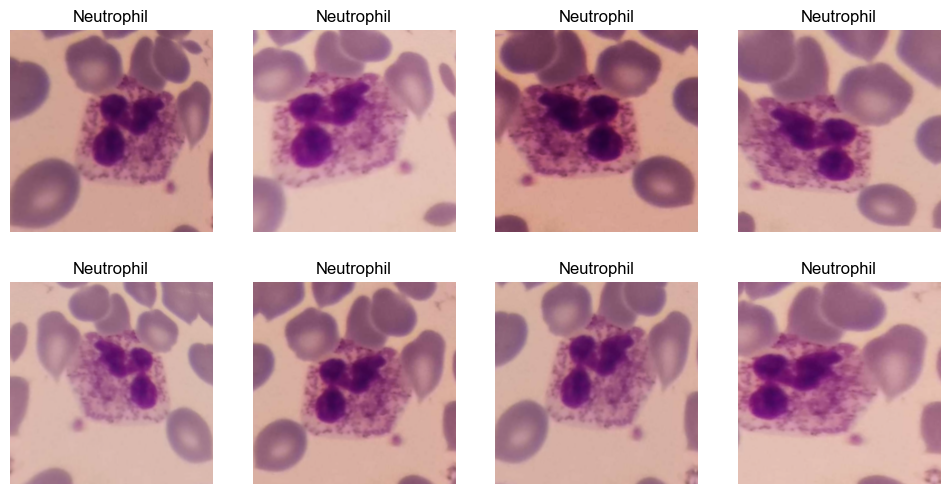

In [34]:
#Modify datablok for image augmentation
white_cell_classifier = white_cell_classifier.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = white_cell_classifier.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [43]:
#Code to generate plots of learning metrics
#Code by Ignacio Oguiza posted at https://forums.fast.ai/t/plotting-metrics-after-learning/69937/2

from matplotlib import pyplot as plt
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()
    

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.640379,0.364892,0.900481,0.099519,03:51


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.176133,0.118921,0.964221,0.035779,03:54
1,0.121729,0.079432,0.975045,0.024955,03:56
2,0.072628,0.068319,0.981058,0.018942,03:57
3,0.041156,0.051101,0.985268,0.014732,03:55
4,0.027314,0.049737,0.984967,0.015033,03:55


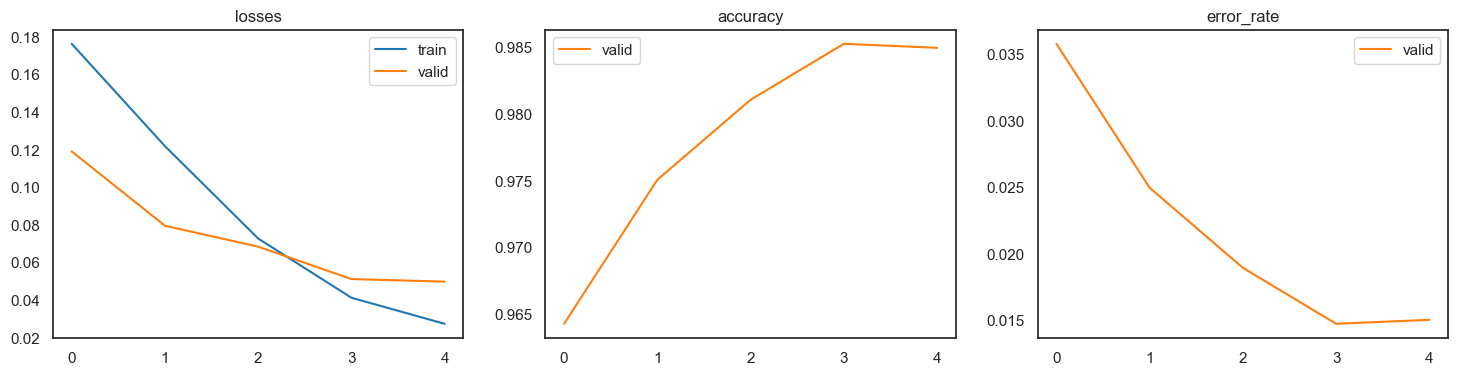

<Figure size 640x480 with 0 Axes>

In [44]:
#Code to fine tune model 
learn = vision_learner(dls, resnet18, metrics=[accuracy, error_rate])
learn.fine_tune(5)
learn.recorder.plot_metrics()
plt.savefig("white_cells_metrics_plot.png")

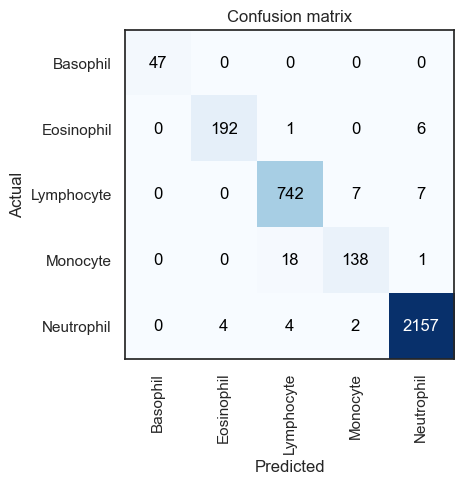

In [46]:
#build a confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
plt.savefig("white_cells_confusion_matrix_plot.png")

In [ ]:
#export model file
learn.export('white_cells_classifier.pkl')


In [16]:
#load model file
learn_inf = load_learner('white_cells_classifier.pkl')

In [17]:
#Inference
learn_inf.predict('neutrophil.jpg')

('Neutrophil',
 tensor(4),
 tensor([1.3694e-05, 4.6679e-04, 7.3109e-03, 1.6164e-04, 9.9205e-01]))